## Anidata
Over the past year or so I have been working with some friends to create a 501(c)3 non-profit organization called <a href="http://anidata.org">Anidata</a>.  Anidata has a two-prong mission: 1) we provide mentorship opportunities where aspiring data scientists can get hands-on experience with real-world data problems in order to improve their skills and 2) we provide data science services to social good organizations that might not otherwise have access to data science capabilities.

{:style="text-align:center" }
![image](../images/anidata.png){:width="180px"}

## Stop Human Trafficking
In our first project as an organization, we supported the Fulton County's District Attorney's office to help find, fight, investigate, and prosecute human trafficking crimes.  In consultation with the DA's office, we learned that many of the investigative steps require manually search adult services websites to build a case.  

## Hackathon
After gathering this initial information, we held a hackathon with Anidata members and law enforcement/DA staff to converge on a concept for a data product that would help them fight human trafficking.  


{:style="text-align:center" }
![image](../images/hackathon.png){:width="330px"}{:vertical-align="middle"} 
![image](../images/hackathon2.png){:width="230px"}{:vertical-align="middle"} 

The hackathon was a big success with over 30 attendees.  Teams presented various project ideas that were in varying states of code completion.  The common theme for a useful product that emerged was a searchable database of internet entities that post on adult ad websites.    

The basic ides would be to allow investigators to take one piece of evidence they might have on an individual under investigation--such as a phone number--and search on that information in a database for all related phone numbers and email addresses.  This helps the DA more efficiently link burner phones to people and posts so that they can build a case.

At the end of the hackathon we had many elements of what would eventually be this search product in place including: 1) a webscraper, 2) a luigi job framework for running daily jobs and dumping the output to a postgresql database, 3) cleaning algorithms to find and clean emails and phone numbers, and 4) an entity resolution algorithm to group postings by entity.

## Entity Resolution (ER)
The core algorithmic challenge in this project was to create an ER algorithm that would group posts by posting entity and allow us to extract a set of emails and phone numbers from those posts to associate with that entity. Let's start by taking a look at the data.


## Data
I've flatten several months of the database data and pruned it down to just the columns we care about.  In the following dataframe each row is a ad posting and the metadata we were able to scrape from that posting. Sample data includes three flat files that pair a `post_id` with an email, user ID, or email address.  We have the following columns:
- name
- phone number
- oid (poster unique ID)
- posterage
- region
- type




### Data 
I have the data for this post stored in <a href="https://github.com/gte620v/graph_entity_resolution/raw/master/data/scraped_data.csv.gz">GitHub</a>.  Let's take a look at the head of the dataframe:

In [2]:
import pandas as pd
df = pd.read_csv(
    'https://github.com/gte620v/graph_entity_resolution/raw/master/data/scraped_data.csv.gz',
    converters={'name': lambda x: str(x).lower(),
                'number': str,
                'oid': str,
                'post_id': str},
    parse_dates=['postdate'],
    compression='gzip')
df.head()

,post_id,name,number,oid,postdate,posterage,region
0,0,,6242414310,9635571,2015-11-28 12:00:00,19.0,birmingham
1,1,,,13957915,2015-12-23 09:13:00,21.0,nashville
2,3,,,33808981,2015-12-24 01:03:00,24.0,miami
3,4,,3059227034,32821362,2015-12-23 01:51:00,35.0,miami
4,6,,6242414310,16767542,2015-12-18 06:20:00,25.0,tampa


## Data Description
To get a better sense of the data, we can use `DataFrame.describe` to find the statistics.

### Ordinal Columns

In [3]:
df[['post_id','name','number','oid','region']].describe(include = 'all')

,post_id,name,number,oid,region
count,232920,232920,232920,232920,232920
unique,232920,1319,21933,194721,18
top,2770,,,21070057,atlanta
freq,1,228994,72361,110,98439


### Age

In [26]:
df[['posterage']].dropna().describe()

,posterage
count,232868.000000
mean,25.678316
std,8.096470
min,18.000000
25%,22.000000
50%,24.000000
75%,27.000000
max,112.000000


### Age Swamplot
<a href="https://stanford.edu/~mwaskom/software/seaborn/index.html">Seaborn</a> has some cool canned functions for examining data distributions by category.  I am particuraly fond `sns.swarmplot` that makes plots like the one below.  The plot  is a sampling of the distribution of first 1000 rows by region and poster age.  Strangely, there are a few posters with ages around 100 years old.

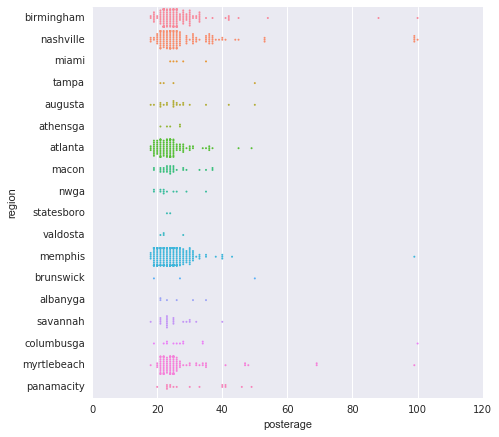

In [69]:
import seaborn as sns
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (7.0, 7.0)

sns.swarmplot(y='region',x='posterage',data=df.head(1000),size=2)

### Post Date

In [5]:
df[['postdate']].describe(include = 'all')

,postdate
count,232920
unique,84966
top,2015-11-24 02:17:00
freq,112
first,2012-10-12 12:22:00
last,2016-02-28 12:59:00


## Entity Resolution

After wrestling with the data a bit, we realized that we can conceptualize the data as a graph and then cluster posts into entities by finding the connected subgraphs.  To do this, our graph has the following semantics:


- Vertices: Ad posts
- Edges: Common attributes (email, phone number, or poster ID)

Our approach is to create subgraphs using each type of edge information and then use subgraph clustering to find the entity subgraphs.  


### Explore Subgraph Sizes

The clustered subgraphs will be entities and each entity will have posted some number of ads.  The block below analyzes the count of the most posted phone numbers.  These are phone numbers that the poster put in the ad as contact information.  The output shows that some phone numbers are associated with over a thousand posts.

In [6]:
df\
.groupby('number')\
.count()\
.sort_values('post_id',ascending=False)[['post_id']]\
.head()

,post_id
number,
,72361
7863556827,1436
4047236489,1336
6242414310,1221
4044511961,945


### Example Sub-Graph

One challenge is to efficiently create the sub graphs. Our first approach was to make fully connected graph out of the data subsets.  But this has the short coming of creating a bunch of graph edges that we will later show are not necessary.  With a fully connected graph of \\\(N\\\) nodes, we will have \\\(N \cdot (N-1)\\\) connections, which is a lot of graph data to store and reason about.

Here is an example of a phone number that is seen on 11 posts:

In [7]:

ph_sample = df[df.number=='7865032020']
ph_sample.sort_values('name',ascending=False).head()

,post_id,name,number,oid,postdate,posterage,region
220676,221500,tucenicienta360@gmail.com,7865032020,26583449,2015-12-22 10:32:00,21.0,miami
134390,134885,tucenicienta360@gmail.com,7865032020,26659871,2015-12-02 11:52:00,21.0,miami
16418,16500,dallaz360@hotmail.com,7865032020,28354889,2015-12-05 04:57:00,22.0,miami
2276,2304,,7865032020,31811642,2015-12-19 10:44:00,25.0,miami
177430,178083,,7865032020,31857356,2015-12-16 09:53:00,24.0,miami


### Fully Connected Subgraph

To create the subgraph we iterate through all pair-wise combinations of posts (a cross join) and populate the networkx graph.  You'll notice in the function below that we also add an attribute to each edge called `d3color`.  

I made a plotting library called <a href="https://github.com/gte620v/pyd3netviz">pyd3netviz</a> to use d3 to visualize network graphs in python (see <a href="">my previous post</a> about it). pyd3netviz can take networkx node an edge attributes as directives for styling the plots.  In this example, out function takes in a rgb tuple called `color` and uses that to specify the edge color.

In [8]:
from pyd3netviz import ForceChart
import itertools

import networkx as nx

def make_graph_data(in_data, data_type, color, G=None):
    ''' Make and plot graph 
    
    do_plot can be 'networkx' or 'pyd3'
    '''
    if G is None:
        G = nx.Graph()
    out = []
    for a, b in itertools.product(in_data, in_data):
        out.append((a, b, {'type': data_type, 'color': color, 
                           'd3color': '#%02x%02x%02x' % tuple(c*255 for c in color)}))
    G.add_edges_from(out)
    return G
    


#### Phone Numbers Only
The example below shows the fully connected subgraph for one phone number (the graph is interactive).  Out high-level ER objective is solved as long as these nodes are connected as a group.  In this case is looks like have the graph fully connected is overkill.

In [9]:
G_samp = make_graph_data(ph_sample.post_id, 'phone', [0,0,1])
width = 590
height = 400
plot_kargs={'charge':-10,'link_distance':200,'width':width,'height':height,
             'default_node_radius':10,'default_link_width':1,
             'link_color_field':'d3color'};
fc =ForceChart(G_samp,**plot_kargs)
fc.to_notebook('../images/graph_phone_only.html')


#### Email Addresses Only
Looking at a set of carefully chosen email addresses, we see the same sort of graph.  I've chosen these email addresses because they share a common post with the phone numbers from the previous example.

In [10]:
em_sample = df[df['name'].str.contains('tuc',False)]
em_sample

,post_id,name,number,oid,postdate,posterage,region
2319,2347,tucenicienta360@gmail.com,7866505040,26588406,2015-12-22 10:27:00,22.0,miami
2320,2348,tucenicienta360@gmail.comhref,7866505040,26588406,2015-12-22 10:27:00,22.0,miami
104393,104780,tucenicienta360@gmail.com,7866505040,26577033,2015-12-14 01:38:00,22.0,miami
134390,134885,tucenicienta360@gmail.com,7865032020,26659871,2015-12-02 11:52:00,21.0,miami
220676,221500,tucenicienta360@gmail.com,7865032020,26583449,2015-12-22 10:32:00,21.0,miami


#### Email Address Graph

In [11]:
G_samp_em = make_graph_data(em_sample.post_id, 'email', [1,0,0])

fc =ForceChart(G_samp_em,**plot_kargs)
fc.to_notebook('../images/graph_email_only.html')

#### Combined Graph with Email and Phone Numbers
If we combine all the posts from the previous two examples and plot them, we notice that they are part of a common ER subgraph that contains the email address `tucenicienta360@gmail.com` and the phone number `7865032020`.  We'll see in a minute that there are other phone numbers connected to this entity as well.  In the plot below the phone number edges are blue and the email address edges are red.  You may have to drag around some of the vertices in order to see the red edges.

In [12]:
out = []
for a, b in itertools.product(em_sample.post_id, em_sample.post_id):
    out.append((a, b, {'type': 'email', 'color': 'r', 'd3color': '#f00'}))
    
G_samp.add_edges_from(out)

fc =ForceChart(G_samp,**plot_kargs)
fc.to_notebook('../images/graph_both.html')

### Simplifying The Graph

The process above works, but having a fully connected set of graphs ends up taking a bunch of memory.  To simplify the graph for our problem, we only need each network of posts to be connected--__not__ fully connected.  To do that, we can create subgraphs that are loosely connected loops instead of densely connected balls of edges.

#### Phone Numbers Only

In [13]:
G_samp_loop = nx.Graph()

# No product for loop
v = ph_sample.post_id.values.tolist()
v_right = v[1:]
if len(v) == 1:
    v_right = v
else:
    v_right[-1] = v[0]
out = [(a, b,{'type':'phone','color':'b', 'd3color': '#00f'}) for a, b in zip(v, v_right)]

G_samp_loop.add_edges_from(out)

colors = [G_samp_loop[u][v]['color'] for u,v in G_samp_loop.edges()]

plot_kargs['charge'] = -150
plot_kargs['link_distance'] = 10

fc =ForceChart(G_samp_loop,**plot_kargs)
fc.to_notebook('../images/graph_loop.html')

#### Phone Numbers and Email Addresses

It is clear that the graph below satisfies our constraint of keeping these nodes connected, while requiring many fewer edges.

In [14]:
v = em_sample.post_id.values.tolist()
v_right = v[1:]
if len(v) == 1:
    v_right = v
else:
    v_right[-1] = v[0]
out += [(a, b,{'type':'phone','color':'r', 'd3color': '#f00'}) for a, b in zip(v, v_right)]

G_samp_loop.add_edges_from(out)


colors = [G_samp_loop[u][v]['color'] for u,v in G_samp_loop.edges()]

fc =ForceChart(G_samp_loop,**plot_kargs)
fc.to_notebook('../images/graph_loop_both.html')


## Graph Clusters
When viewed this way, a set of connected posts (vertices) and poster attributes (edges) constitute an entity.  With that clear, we simply have to create a graph out of all connections and then find the disjoint subgraphs.  The function below takes one form of edge information and makes a connectivity list.

In [15]:
def make_graph(df, color, data_type):
    '''
    Makes a list of tuple lists for each node-edge-node segment in the graph
    '''
    out = []
    for i, (k, v) in enumerate(df.groupby(df.columns[-1])):
        
        v = v.values.tolist()
        v = [x[0] for x in v]
        v_right = v[1:]
        if len(v) == 1:
            v_right = v
        else:
            v_right[-1] = v[0]
        out.append([(a, b, {'type': data_type,
                            'color': color, 
                           'd3color': '#%02x%02x%02x' % tuple(c*255 for c in color)}) for a, b in zip(v, v_right)])
    out = [item for sublist in out for item in sublist]
    return out

### Add Graphs for Each Type of Connection
For each identifying attribute, use `make_graph` to generate the connectivity list and then combine all lists.

In [16]:
out = make_graph(df[df.name!=''][['post_id','name']],[1,0,0],'email')
out += make_graph(df[df.number!=''][['post_id','number']],[0,0,1],'number')
out += make_graph(df[df.oid!=''][['post_id','oid']],[0,1,0],'oid')

### Use NetworkX to Find Disjoint SubGraphs
Now that we have the mast graph, we can use NetworkX to find all subgraphs and then loop through them to find each distinct entity.

In [17]:
G = nx.Graph()
G.add_edges_from(out)

sub_graphs = []
for i, x in enumerate(nx.connected_component_subgraphs(G)):
    nodes = nx.nodes(x)
    sub_graphs.append(list(zip([i] * len(nodes), nodes)))

sub_graphs = [item for sublist in sub_graphs for item in sublist]



### Check Entity Data
To check the entities we can start by just looking at the number of posts associated with each entity id.  That is, the number of posts in each disjoint subgraph.  

In [30]:
df_out = pd.DataFrame(sub_graphs,
                      columns=['entity_id',
                               'post_id'])
df_out.groupby('entity_id').count().head(10)

,post_id
entity_id,
0,1
1,69
2,1
3,1
4,5
5,1
6,1
7,32
8,1337


### Merge With Original Data

Finally, we use the entity dataframe to join back in the post data so that we can can see the identity data for each entity.

In [41]:

df_out = df_out.merge(df,on='post_id')
df_out.set_index(['entity_id','number','name','oid'],inplace=True)
df_out.head(5)

post_id  \
entity_id number     name                               oid                
0                    hilariakpbeastonqb1733@hotmail.com 34025515   28269   
1         7067233248                                    34006088  174300   
                                                        34532481  188893   
                                                        34888139   87405   
                                                        36217461  212311   

                                                                            postdate  \
entity_id number     name                               oid                            
0                    hilariakpbeastonqb1733@hotmail.com 34025515 2015-11-20 11:23:00   
1         7067233248                                    34006088 2015-11-19 06:16:00   
                                                        34532481 2015-12-06 04:37:00   
                                                        34888139 2015-12-18 02:59:00   
                                                        36217461 2016-02-05 07:19:00   

                                                                  posterage  \
entity_id number     name                               oid                   
0                    hilariakpbeastonqb1733@hotmail.com 34025515       24.0   
1         7067233248                                    34006088       27.0   
                                                        34532481       27.0   
                                                        34888139       27.0   
                                                        36217461       27.0   

                                                                      region  
entity_id number     name                               oid                   
0                    hilariakpbeastonqb1733@hotmail.com 34025515  columbusga  
1         7067233248                                    34006088     augusta  
                                                        34532481     augusta  
                                                        34888139     augusta  
                                                        36217461     augusta

## Check Results
To check the results, let's look at the entity we started to manually analyze in the first examples.  If we search this entity table by email address we see two phone numbers attached to the entity including the one we originally experimented with.  That seems reasonable.

In [50]:
df_out.query('name=="tucenicienta360@gmail.com"')

post_id  \
entity_id number     name                      oid                
9405      7865032020 tucenicienta360@gmail.com 26659871  134885   
          7866505040 tucenicienta360@gmail.com 26588406    2347   
          7865032020 tucenicienta360@gmail.com 26583449  221500   
          7866505040 tucenicienta360@gmail.com 26577033  104780   

                                                                   postdate  \
entity_id number     name                      oid                            
9405      7865032020 tucenicienta360@gmail.com 26659871 2015-12-02 11:52:00   
          7866505040 tucenicienta360@gmail.com 26588406 2015-12-22 10:27:00   
          7865032020 tucenicienta360@gmail.com 26583449 2015-12-22 10:32:00   
          7866505040 tucenicienta360@gmail.com 26577033 2015-12-14 01:38:00   

                                                         posterage region  
entity_id number     name                      oid                         
9405      7865032020 tucenicienta360@gmail.com 26659871       21.0  miami  
          7866505040 tucenicienta360@gmail.com 26588406       22.0  miami  
          7865032020 tucenicienta360@gmail.com 26583449       21.0  miami  
          7866505040 tucenicienta360@gmail.com 26577033       22.0  miami

## Check Entity
Taking that `entity_id`, we can see all the connected posts.  We can see a variety of phone numbers, emails, and post locations.

In [53]:
entity_id = df_out.query('name=="tucenicienta360@gmail.com"').index.get_level_values('entity_id')[0]
df_out.query('entity_id=={}'.format(entity_id)).head(20)

post_id  \
entity_id number     name                      oid                
9405      7865032020                           31856922   31784   
                                               33889430  138814   
          7866505040                           28384098   16562   
          7865032020                           28372705   20101   
                     tucenicienta360@gmail.com 26659871  134885   
                                               31838170   46451   
                                               28561650   52095   
                                               31854569  119535   
                                               31857356  178083   
                                               31300988  122688   
          7866505040                           34155477    2287   
          7865032020                           31837041  221367   
                                               31837101  119466   
          7866505040                           31331761  119485   
          7865032020                           28561650  147990   
                                               35289414   45955   
                                               31811642    2304   
                     dallaz360@hotmail.com     28354889   16500   
                                               33495618  206457   
          7866505040                           31811398  206968   

                                                                   postdate  \
entity_id number     name                      oid                            
9405      7865032020                           31856922 2015-12-19 11:52:00   
                                               33889430 2016-02-13 03:58:00   
          7866505040                           28384098 2015-12-17 11:28:00   
          7865032020                           28372705 2016-01-08 02:16:00   
                     tucenicienta360@gmail.com 26659871 2015-12-02 11:52:00   
                                               31838170 2015-12-22 10:30:00   
                                               28561650 2016-01-25 10:17:00   
                                               31854569 2015-12-23 11:52:00   
                                               31857356 2015-12-16 09:53:00   
                                               31300988 2016-01-18 10:59:00   
          7866505040                           34155477 2015-12-17 03:30:00   
          7865032020                           31837041 2015-12-05 04:52:00   
                                               31837101 2015-12-17 02:56:00   
          7866505040                           31331761 2015-12-19 11:51:00   
          7865032020                           28561650 2015-12-22 10:29:00   
                                               35289414 2015-12-24 10:32:00   
                                               31811642 2015-12-19 10:44:00   
                     dallaz360@hotmail.com     28354889 2015-12-05 04:57:00   
                                               33495618 2015-12-08 05:23:00   
          7866505040                           31811398 2015-12-09 10:51:00   

                                                         posterage region  
entity_id number     name                      oid                         
9405      7865032020                           31856922       25.0  miami  
                                               33889430       23.0  miami  
          7866505040                           28384098       23.0  miami  
          7865032020                           28372705       22.0  miami  
                     tucenicienta360@gmail.com 26659871       21.0  miami  
                                               31838170       23.0  miami  
                                               28561650       24.0  miami  
                                               31854569       23.0  miami  
                                               31857356       24.0  miami  
      

## Plot Network
Finally, we can get a sense of the network by plotting a subset of 50 entities. There are several orphan posts that aren't connected to an entity as well as several large entities with many connected posts.  A quick glance at the plot shows that most of the ID information are phone numbers (blue edges), with a few email addresses (red) and poster_ids (green) sprinkled in.

In [54]:
G_check = G.subgraph(df_out.loc[560:610].post_id.values)

pos = nx.spring_layout(G_check)
colors = [G_check[u][v]['color'] for u,v in G_check.edges()]

plot_kargs['charge'] = -5
plot_kargs['link_distance'] = 5
plot_kargs['default_node_radius'] = 2
plot_kargs['height'] = 600

fc =ForceChart(G_check,**plot_kargs)
fc.to_notebook('../images/graph_final.html')

## NetworkX Plot
NetworkX also has a plotting tool that we can use to see the graph.  The block below shows how we use nx to make the same plot.

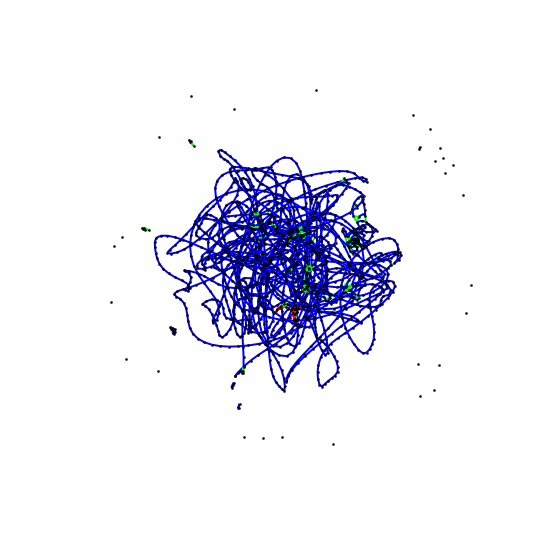

In [63]:
rcParams['figure.figsize'] = (7.0, 7.0)
nx.draw(G_check,pos,node_color='k',edge_color=colors,width=2,node_size=5)

## Resources

- Talk notebook on <a href="https://github.com/gte620v/graph_entity_resolution">GitHub</a>
- Talk slides on <a href="https://docs.google.com/presentation/d/1r3SAci6PRdddPec606zLMXRONWDL9xjbQMWy7oDeEVU/pub?start=false&loop=false&delayms=60000">Google Slides</a>
- Anidata 1.x code for this Stop Human Trafficking project is on <a href="https://github.com/anidata">GitHub</a>


